# Dataset and Benchmark creation with `Polaris`
The first step of creating a benchmark is to set up a standard dataset which allows accessing the curated dataset (which has been demonstrated in <07_01_polaris_adme-fang-1_data_curation.ipynb>), and all necessary information about the dataset such as data source, description of endpoints, units etc. 

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pathlib

import datamol as dm

# polaris benchmark
from polaris.benchmark import SingleTaskBenchmarkSpecification

# polaris hub
from polaris.utils.types import HubOwner

# utils
root = pathlib.Path("__file__").absolute().parents[3]
os.chdir(root)
sys.path.insert(0, str(root))
from utils.docs_utils import load_readme

In [2]:
# Get the owner and organization

org = "novatis"
data_name = "CYP"
dirname = dm.fs.join(root, f"org-{org}", data_name)
gcp_root = f"gs://polaris-public/polaris-recipes/org-{org}/{data_name}"

dataset_name = 'novatis_cyp3a4-v1'

owner = HubOwner(slug=org, type="organization")
owner

HubOwner(slug='novatis', external_id=None, type='organization')

In [3]:
BENCHMARK_DIR = f"{gcp_root}/benchmarks"
DATASET_JSON = "gs://polaris-public/polaris-recipes/org-novatis/CYP/datasets/novatis_cyp3a4-v1/dataset.json"

FIGURE_DIR =  f"{gcp_root}/figures"

## Load existing dataset object



In [4]:
# Load the saved Dataset
from polaris.dataset import Dataset

dataset = Dataset.from_json(DATASET_JSON)

In [5]:
dataset

{
  "name": "novatis_cyp3a4-v1",
  "description": "CYP3A4 Time-Dependent Inhibition data released by Novartis",
  "tags": [
    "ADME"
  ],
  "user_attributes": {
    "year": "2024"
  },
  "owner": "novartis",
  "polaris_version": "dev",
  "default_adapters": {},
  "zarr_root_path": null,
  "md5sum": "dcefee6bdae2a0c8224ea14a54e8b7ad",
  "readme": "",
  "annotations": {
    "MOL_smiles": {
      "is_pointer": false,
      "modality": "MOLECULE",
      "description": "Molecule SMILES string",
      "user_attributes": {},
      "dtype": "object"
    },
    "log_kobs": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": "Log unit of TDI CYP3A4 inactivation.",
      "user_attributes": {},
      "dtype": "float64"
    },
    "CLS_log_kobs": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": "Three-class binning on TDI CYP3A4 inactivation  0.01 and 0.025.",
      "user_attributes": {},
      "dtype": "float64"
    },
    "pIC50_CYP3A4": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": "Reversible CYP3A4 inhibition pIC50 values.",
      "user_attributes": {},
      "dtype": "float64"
    },
    "pIC50_CYP2C9": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": "Reversible CYP2C9 inhibition pIC50 values.",
      "user_attributes": {},
      "dtype": "float64"
    },
    "pIC50_CYP2D6": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": "Reversible CYP2D6 inhibition pIC50 values.",
      "user_attributes": {},
      "dtype": "float64"
    },
    "split": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": "Train and test splitting from the original publication doi.org/10.1021/acs.chemrestox.3c00305",
      "user_attributes": {},
      "dtype": "object"
    }
  },
  "source": "https://opendata.ncats.nih.gov/adme/data",
  "license": "CC-BY-4.0",
  "curation_reference": "https://github.com/polaris-hub/polaris-recipes/org-Polaris/org-Novartis/CYP/00_CYP3A4_data_processing.ipynb",
  "cache_dir": "/Users/lu.zhu/Library/Caches/polaris/datasets/novatis_cyp3a4-v1/dcefee6bdae2a0c8224ea14a54e8b7ad",
  "artifact_id": "novartis/novatis-cyp3a4-v1",
  "n_rows": 16740,
  "n_columns": 7
}

## Benchmark creation with `Polaris`
Creating a benchmark involves setting up a standard dataset, designing the train-validation-test set and defining evaluation metrics which is used to establish baseline performance level. 

In [6]:
dataset.columns

['MOL_smiles',
 'log_kobs',
 'CLS_log_kobs',
 'pIC50_CYP3A4',
 'pIC50_CYP2C9',
 'pIC50_CYP2D6',
 'split']

In [8]:
mol_col = 'MOL_smiles'
data_cols = ['CLS_log_kobs']

## Create a Benchmark as in published paper
The train/test sets are pre-defined in `doi.org/10.1021/acs.chemrestox.3c00305`

In [9]:
train_split = dataset.table.query("split == 'train'").index.values
test_split = dataset.table.query("split == 'test'").index.values

### Check distribution of train/test set in the chemical space

  0%|          | 0/16740 [00:00<?, ?it/s]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


'https://storage.googleapis.com/polaris-public/polaris-recipes/org-novatis/CYP/figures/paper_split_chemspace.png'

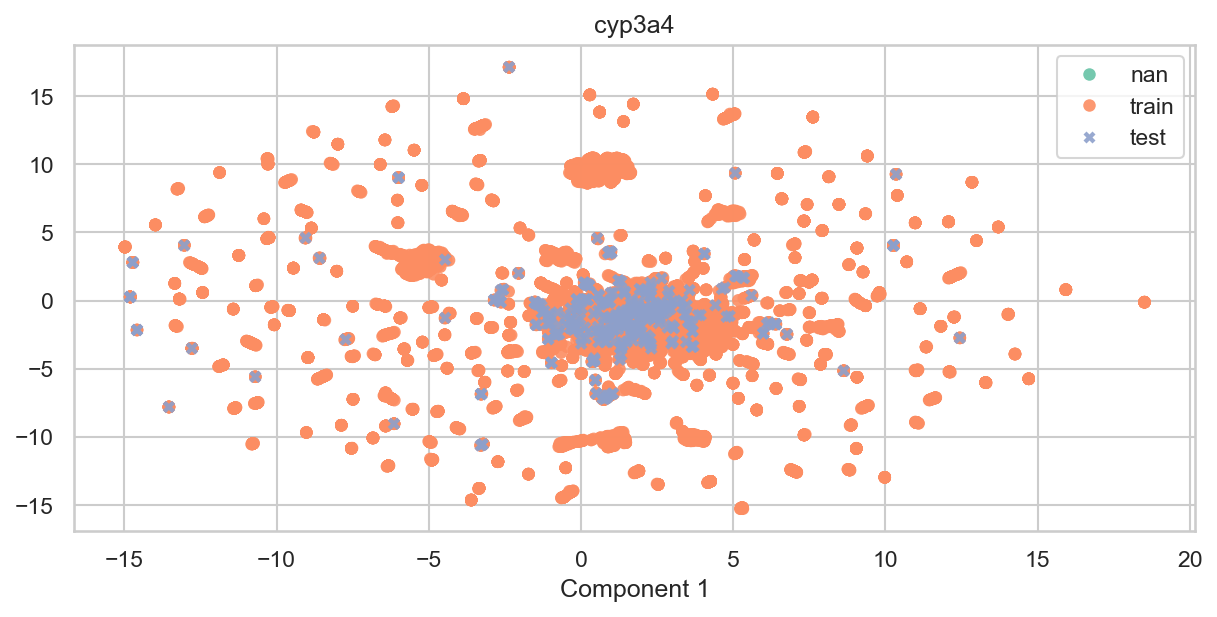

In [10]:
from utils.docs_utils import visualize_split_chemspace

fig = visualize_split_chemspace(mols=dataset.table[mol_col].to_list(), 
                                train_test_dict={"cyp3a4": (train_split, test_split)})

# export the figure to remote path
from utils.auroris_utils import save_image
save_image(fig, dm.fs.join(FIGURE_DIR, f"paper_split_chemspace.png"))

## Single classification task on `CLS_log_kobs`

In [11]:
benchmark_path = {}

benchmark_name = "adme-novartis-cyp3a4-cls"

benchmark_cls = SingleTaskBenchmarkSpecification(
    name=benchmark_name,
    dataset=dataset,
    target_cols=data_cols,
    target_types={col: "classification" for col in data_cols},
    input_cols=mol_col,
    split=(train_split, test_split), 
    main_metric="balanced_accuracy",
    metrics=["balanced_accuracy"],
    tags=["ADME", "SingleTask"],
    owner=HubOwner(user_id="Novartis", slug="novartis"),
    description=f"Single classification task benchmark for CYP3A4 {data_cols[0]}",
)
BENCHMARK_SAVE_DIR = f"{BENCHMARK_DIR}/{benchmark_name}"
path = benchmark_cls.to_json(BENCHMARK_SAVE_DIR)
print(path)

gs://polaris-public/polaris-recipes/org-novatis/CYP/benchmarks/adme-novartis-cyp3a4/benchmark.json


In [12]:
# Upload to hub
# benchmark_cls.upload_to_hub(owner=owner, access="private") 

## Single regression task on `log Kobs`

In [18]:
benchmark_name = "adme-novartis-cyp3a4-reg"
target_col = "log_kobs"

benchmark_reg = SingleTaskBenchmarkSpecification(
    name=benchmark_name,
    dataset=dataset,
    target_cols=target_col,
    target_types={target_col:"regression"},
    input_cols=mol_col,
    split=(train_split, test_split), 
    main_metric="absolute_average_fold_error",  
    metrics=[ "absolute_average_fold_error", "mean_absolute_error",
        "mean_squared_error",
        "r2",
        "spearmanr",
        "pearsonr",
        "explained_var",
        ],
    tags=["ADME", "SingleTask"],
    owner=HubOwner(user_id="Novartis", slug="novartis"),
    description=f"Single regression task benchmark for CYP3A4 {target_col}",
)
BENCHMARK_SAVE_DIR = f"{BENCHMARK_DIR}/{benchmark_name}"
path = benchmark_reg.to_json(BENCHMARK_SAVE_DIR)
print(path)

gs://polaris-public/polaris-recipes/org-novatis/CYP/benchmarks/adme-novartis-cyp3a4-reg/benchmark.json


In [14]:
# Upload to hub
# benchmark_reg.upload_to_hub(owner=owner, access="private") 

## Multitask regression task

In [21]:
benchmark_name = "adme-novartis-cyp-multitask-reg"
target_cols = ["log_kobs", "pIC50_CYP3A4", "pIC50_CYP2C9", "pIC50_CYP2D6"]

benchmark_multi_reg = SingleTaskBenchmarkSpecification(
    name=benchmark_name,
    dataset=dataset,
    target_cols=target_col,
    target_types={target_col:"regression"},
    input_cols=mol_col,
    split=(train_split, test_split), 
    main_metric="absolute_average_fold_error",
    metrics=[ "absolute_average_fold_error", "mean_absolute_error",
        "mean_squared_error",
        "r2",
        "spearmanr",
        "pearsonr",
        "explained_var",
        ],
    tags=["ADME", "MultiTask"],
    owner=HubOwner(user_id="Novartis", slug="novartis"),
    description=f"Multitask regression task benchmark for CYP3A4, CYP2C9, CYP2D6 ",
)
BENCHMARK_SAVE_DIR = f"{BENCHMARK_DIR}/{benchmark_name}"
path = benchmark_multi_reg.to_json(BENCHMARK_SAVE_DIR)
print(path)

gs://polaris-public/polaris-recipes/org-novatis/CYP/benchmarks/adme-novartis-cyp-multitask-reg/benchmark.json


In [ ]:
# Upload to hub
# benchmark_multi_reg.upload_to_hub(owner=owner, access="private") 